Assigment 4 Exercise 2

In [1]:
import numpy as np
import pandas as pd
import random as random
import matplotlib.pyplot as plt
import scipy.stats as ss
from datetime import datetime
import wrds
db = wrds.Connection(wrds_username = 'anita97') 

Loading library list...
Done


a) Download daily returns for Amazon, the market and t-bill (which represents the risk free)

In [2]:
# Amazon
amazon = db.raw_sql("select date, " "ret from crsp.dsf where permno in (84788)" "and date >='2009-01-01' and date<='2019-12-31'")

# Market
rm = db.raw_sql("select date, vwretd from crsp.dsi where date >='2009-01-01' and date<='2019-12-31'")

# T-bill
rf = db.raw_sql("select caldt, tdyld from crsp.tfz_dly_rf2 where kytreasnox = 2000061 and caldt  >='2009-01-01' and caldt<='2019-12-31'")

In [3]:
name = ['Amazon','Market','Tbill']

# rename the index column:
amazon.set_index('date') 
rm.set_index('date')
rf.set_index('caldt') 

# rename the value column:
amazon = amazon.rename(columns={'ret':name[0]})
rm = rm.rename(columns={'vwretd':name[1]})
rf = rf.rename(columns={'tdyld':name[2]})
rf = rf.rename(columns={'caldt': 'date'})

# merge variables:
data1 = pd.merge(amazon, rm, on= 'date',validate="one_to_one")
data = pd.merge(data1, rf, on= 'date',validate="one_to_one").set_index("date")
data.index = pd.DatetimeIndex(data.index) # convert index in DataIndex
data.head()

,Amazon,Market,Tbill
date,,,
2009-01-02,0.060062,0.030505,5.555597e-07
2009-01-05,-0.005519,-0.000581,1.250019e-06
2009-01-06,0.061043,0.011304,2.777787e-07
2009-01-07,-0.020223,-0.030490,7.638953e-07
2009-01-08,0.017082,0.006286,6.944512e-07


In [4]:
display(data.describe()) # statistical description

,Amazon,Market,Tbill
count,2747.000000,2747.000000,2.747000e+03
mean,0.001527,0.000563,1.313021e-05
std,0.021138,0.010362,2.014125e-05
min,-0.126568,-0.068697,-1.111094e-06
25%,-0.008656,-0.003688,6.250055e-07
50%,0.000930,0.000785,2.638969e-06
75%,0.011749,0.005596,1.854605e-05
max,0.267951,0.069068,6.727651e-05


b) Plot the rolling window esimate of the beta of the stock using 6-mount data window

In [5]:
# calculate rolling covariance:
sixmounths_data = data.rolling('183D') # 183 days are half a year (6 mounths)
cov_6m = sixmounths_data.cov() # covariance 
cov_6m = cov_6m.loc['2009-06-01':'2018-12-31'] # rename data

print('Covariance between Amazon, market and risk free of rolled data (6 mounths):')
cov_6m.head(9)

Covariance between Amazon, market and risk free of rolled data (6 mounths):


Amazon        Market         Tbill
date                                                       
2009-06-01 Amazon  1.343424e-03  5.093278e-04  5.623520e-09
           Market  5.093278e-04  5.779444e-04 -2.787182e-09
           Tbill   5.623520e-09 -2.787182e-09  3.044690e-12
2009-06-02 Amazon  1.333258e-03  5.047033e-04  5.669403e-09
           Market  5.047033e-04  5.723690e-04 -2.748932e-09
           Tbill   5.669403e-09 -2.748932e-09  3.018639e-12
2009-06-03 Amazon  1.320544e-03  4.992653e-04  5.649241e-09
           Market  4.992653e-04  5.701144e-04 -2.913258e-09
           Tbill   5.649241e-09 -2.913258e-09  3.000814e-12

Text(0.5, 0, 'Time')

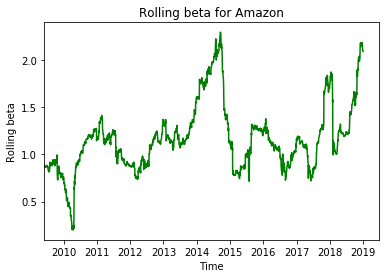

In [6]:
# calculate the rolling beta
time = [] # x axis
beta = [] # y axis
cov_ma = []
var_m = []
range_index = int(np.divide(len(cov_6m),3))

for i in range(range_index):
    index = i*3 # index+0 is Amazon, index+1 is market, index+2 is the rf
    time.append(cov_6m.index[index][0])
    cov_ma.append(cov_6m.Market.iloc[index]) # index+0 is amazon
    var_m.append(cov_6m.Market.iloc[index+1]) # index+1 is market
    beta.append(np.divide(cov_ma[-1],var_m[-1]))

# plot the rolling beta
plt.plot(time,beta, color='g')
plt.xlim(time[1]) 
plt.title('Rolling beta for Amazon')
plt.ylabel('Rolling beta')
plt.xlabel('Time')

c) Illustate sampling variation: simulate 10 years of data for a stock that satisfies the CAPM equation and has a constant beta equal to the average you estimated over the 10 years for your stock

risk premium : excess return that investing in the stock market provides over a risk-free rate

Risk_premium(t) = Amazon(i) - Risk_Free(i) 

Excess_return(t) = Market(i) - Risk_Free(i)

In [7]:
# add risk premium and excess reyrn to data
risk_premium = data.Amazon - data.Tbill
excess_return = data.Market - data.Tbill
data = data.assign( RiskPremium=risk_premium )
data = data.assign( ExcessReturn=excess_return )
data.head()

,Amazon,Market,Tbill,RiskPremium,ExcessReturn
date,,,,,
2009-01-02,0.060062,0.030505,5.555597e-07,0.060062,0.030504
2009-01-05,-0.005519,-0.000581,1.250019e-06,-0.005520,-0.000582
2009-01-06,0.061043,0.011304,2.777787e-07,0.061043,0.011304
2009-01-07,-0.020223,-0.030490,7.638953e-07,-0.020224,-0.030491
2009-01-08,0.017082,0.006286,6.944512e-07,0.017081,0.006286


The fixed beta is .2f


Text(0, 0.5, 'excess return')

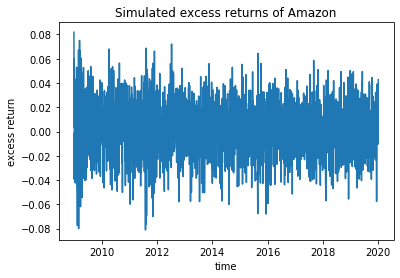

In [8]:
constant_beta = np.array(beta).mean() # constant beta
print('The fixed beta is .2f' %[constant_beta])

# idyomatic risk
data_epsilon = data.Amazon - data.Tbill - constant_beta * data.ExcessReturn
std_eps = data_epsilon.std()
normal_epsilon = np.random.normal(0,std_eps,len(data)) # normal simulation of epsilon

excess_return_sim = normal_epsilon + constant_beta * data.ExcessReturn
data = data.assign(SimulatedData = excess_return_sim)

# plot
plt.plot(excess_return_sim)
plt.title('Simulated excess returns of Amazon')
plt.xlabel('time')
plt.ylabel('excess return')

In [9]:
data.head()

,Amazon,Market,Tbill,RiskPremium,ExcessReturn,SimulatedData
date,,,,,,
2009-01-02,0.060062,0.030505,5.555597e-07,0.060062,0.030504,0.081858
2009-01-05,-0.005519,-0.000581,1.250019e-06,-0.005520,-0.000582,0.003373
2009-01-06,0.061043,0.011304,2.777787e-07,0.061043,0.011304,0.059828
2009-01-07,-0.020223,-0.030490,7.638953e-07,-0.020224,-0.030491,-0.039405
2009-01-08,0.017082,0.006286,6.944512e-07,0.017081,0.006286,-0.001135


d) Plot the rolling-window estimate for the beta using the same code as in (2) above
but using the simulated data. On the same graph, plot the adjusted beta series
(using the Bloomberg formula) and the actual constant beta.


In [10]:
data_simulated = data[['Market','Tbill','SimulatedData']] # extract only needed columns
cov_6m_simulated =  data_simulated.rolling('183D').cov() # covariance 
cov_6m_simulated = cov_6m_simulated.loc['2009-06-01':'2018-12-31'] # rename data
cov_6m_simulated.head(9)

Market         Tbill  SimulatedData
date                                                               
2009-06-01 Market         5.779444e-04 -2.787182e-09   6.582610e-04
           Tbill         -2.787182e-09  3.044690e-12  -8.725666e-09
           SimulatedData  6.582610e-04 -8.725666e-09   1.109062e-03
2009-06-02 Market         5.723690e-04 -2.748932e-09   6.520430e-04
           Tbill         -2.748932e-09  3.018639e-12  -8.586745e-09
           SimulatedData  6.520430e-04 -8.586745e-09   1.099132e-03
2009-06-03 Market         5.701144e-04 -2.913258e-09   6.502928e-04
           Tbill         -2.913258e-09  3.000814e-12  -8.769532e-09
           SimulatedData  6.502928e-04 -8.769532e-09   1.094850e-03

Text(0.5, 0, 'Time')

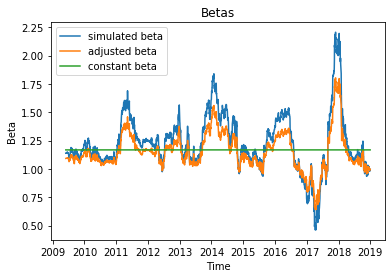

In [11]:
# rolling simulated beta:
beta_sim = [] # y axis
cov_ma_sim = []
var_m_sim = []
range_index = int(np.divide(len(cov_6m),3))

for i in range(range_index):
    index = i*3 # index+0 is market, index+1 is Rf, index+2 is the simulated amazon
    cov_ma_sim.append(cov_6m_simulated.Market.iloc[index+2]) # index+2 is simulated amazon
    var_m_sim.append(cov_6m_simulated.Market.iloc[index]) # index+0 is market
    beta_sim.append(np.divide(cov_ma_sim[-1],var_m_sim[-1]))

# adjusted beta
adjusted_beta = [(b * 2/3 + 1/3) for b in beta_sim]

#constant beta
vector_con_beta = [constant_beta]*(len(beta))

#plot
line1 = plt.plot(time,beta_sim, label='simulated beta')
line2 = plt.plot(time,adjusted_beta, label='adjusted beta')
line3 = plt.plot(time,vector_con_beta, label='constant beta')
plt.legend()
#plt.legend((line1, line2, line3), ('simulated beta', 'adjusted beta', 'constant beta'))
plt.title('Betas')
plt.ylabel('Beta')
plt.xlabel('Time')
